# Projet Télédétection Avancée UE:901_2  + Qualité et Fouille UE: 906

NOM: DASSI FENGAING 
Prénom: Alain Théophile

Données utilisées: pyrenees_24-25 et échantillons PI_strates_pyrenees_32630


# Introduction Générale

La classification d’images de télédétection constitue une étape clé pour transformer des données brutes en cartes thématiques exploitables. Elle permet d’identifier et de discriminer différents types de surfaces (sols nus, végétation, zones artificialisées, cultures, etc.) à partir de leurs signatures spectrales. Les méthodes de classification supervisée, et notamment celles basées sur l’apprentissage automatique, offrent aujourd’hui des performances élevées et une grande capacité de généralisation, à condition d’être correctement paramétrées et validées.

Ce projet s’inscrit dans cette dynamique et vise à mettre en œuvre une chaîne complète de traitement d’images allant du prétraitement des données jusqu’à la production d’une image classifiée finale constituée des classes comme du sol nu, herbe, landes et arbre. Il mobilise des outils de traitement numérique et des bibliothèques scientifiques afin de manipuler les données raster, entraîner un modèle de classification, évaluer l’importance des variables utilisées et générer une sortie cartographique cohérente et exploitable dans un SIG.

Une attention particulière est portée à la gestion des valeurs NoData, à la cohérence radiométrique et à la compatibilité des résultats avec les logiciels de cartographie tels que QGIS. L’objectif final est de produire une carte fiable et interprétable, tout en respectant les bonnes pratiques en télédétection et en traitement des données géospatiales.

Ce travail permet ainsi de consolider des compétences à la fois théoriques et pratiques en télédétection, en analyse spatiale et en programmation appliquée, tout en répondant à des enjeux concrets de production et de qualité de l’information géographique.

In [2]:
# Importation des librairies utiles
import sys
sys.path.append('/home/onyxia/work/libsigma')
import os
import pandas as pd
import geopandas as gpd
from datetime import datetime
import classification as cla
import matplotlib.pyplot as plt
import read_and_write as rw
import matplotlib.cm as cm
import plots
from osgeo import gdal, osr, ogr
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import confusion_matrix, classification_report, \
accuracy_score

# Ma fonction personnel
sys.path.append('/home/onyxia/work/Projet_Teledetection_UE901_21')
import my_function as mf

In [3]:
# Dossier de travail
mon_dossier = '/home/onyxia/work/'

## 1. Analyse des échantillons

Cette première partie vise à analyser les échantillons des classes d’occupation du sol afin d’évaluer leur répartition et leur représentativité. Elle permet notamment de déterminer le nombre d’échantillons et de polygones par classe, ainsi que le nombre de pixels associés à chaque classe.

In [24]:
# Chargement des strates d'échantillons
fichier_strates = os.path.join(mon_dossier,'data/projet_eval/PI_strates_bretagne_32630.shp')
gdf_strates = gpd.read_file(fichier_strates)
#print('type of gdf : ', type(gdf))
gdf_strates

,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."
...,...,...,...,...
273,93,2,None,"POLYGON ((443136.988 5365585.443, 443137.387 5..."
274,94,2,None,"POLYGON ((442889.656 5365477.231, 442891.451 5..."
275,95,3,None,"POLYGON ((443014.607 5365879.437, 443015.006 5..."
276,96,3,None,"POLYGON ((442863.383 5365747.022, 442864.38 53..."


In [25]:
print("Nombre total de polygones :", len(gdf_strates))
print("\nSystème de projection :")
print(gdf_strates.crs)

Nombre total de polygones : 278

Système de projection :
EPSG:32630


### Nombre de polygones par classe.

strate
2     86
3    121
4     71
Name: count, dtype: int64


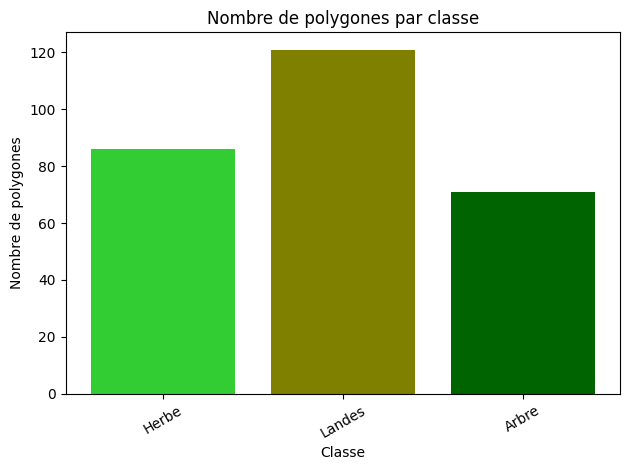

<Figure size 640x480 with 0 Axes>

In [26]:
# Nom du champ de classe 
field_name = "strate"

# Nomenclature des classes et couleurs
class_names = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

class_colors = {
    1: "saddlebrown",
    2: "limegreen",
    3: "olive",
    4: "darkgreen"
}

# Comptage des polygones par classe
counts_poly = gdf_strates[field_name].value_counts().sort_index()

# Remplacer les codes par les noms et couleurs
labels = [class_names[c] for c in counts_poly.index]
colors = [class_colors[c] for c in counts_poly.index]

# affficher nombre de polygone par classe
print(counts_poly)

# diagramme en bar des nombres de polygones par classe
plt.figure()
plt.bar(labels, counts_poly.values, color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Enregistrement dans le répertoire figure
plt.savefig(os.path.join(mon_dossier,"Projet_Teledetection_UE901_21/resultats/figure/diag_baton_nb_poly_by_class.png"), dpi=300)

#### Commentaires
Les résultats montrent une dominance de la classe Landes (classe 3), qui possède le plus grand nombre de polygones. La classe Herbe (classe 2) arrive en seconde position, suivie par la classe Arbre (classe 4). En revanche, la classe Sol nu (classe 1) est faiblement représentée, ce qui indique une présence limitée de surfaces nues dans les échantillons analysés.

## Nombre de pixel par classe.

### Rasterization des échantillons




In [27]:
# Rasterization des echantillon polygonale 
out_sample_raster =  os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/figure/sample_raster223.tif')
#ref_image = gdal.Open(image)
#cla.rasterization(fichier_strates, image, out_sample_raster, field_name)
fichier_ref = os.path.join(mon_dossier,"data/projet_eval/pyrenees_24-25_B03.tif")

field_name = "strate"

#mf.rasterize_shapefile(fichier_strates, fichier_ref, out_sample_raster, field_name)

In [28]:

def rasterize_shapefile(fichier_strates, out_sample_raster, attribute, 
                        pixel_size=10, nodata_value=0, output_format='GTiff'):
    """
    Rasterise un shapefile en fichier raster.
    
    Paramètres:
        fichier_strates (str): Chemin vers le shapefile d'entrée
        out_sample_raster (str): Chemin vers le raster de sortie
        attribute (str): Nom de l'attribut à rasteriser
        pixel_size (float): Taille du pixel en unités de la projection (défaut: 10)
        nodata_value (float): Valeur pour les pixels sans données (défaut: 0)
        output_format (str): Format de sortie GDAL (défaut: 'GTiff')
    
    Retourne:
        bool: True si succès, False sinon
    """
    
    # Ouvrir le shapefile
    vector_ds = ogr.Open(fichier_strates)
    if vector_ds is None:
        print(f"Erreur: Impossible d'ouvrir {fichier_strates}")
        return False
    
    layer = vector_ds.GetLayer()
    
    # Récupérer l'étendue du shapefile
    x_min, x_max, y_min, y_max = layer.GetExtent()
    
    # Calculer les dimensions du raster
    x_res = int((x_max - x_min) / pixel_size)
    y_res = int((y_max - y_min) / pixel_size)
    
    # Récupérer la projection du shapefile
    srs = layer.GetSpatialRef()
    
    # Créer le raster de sortie
    driver = gdal.GetDriverByName(output_format)
    target_ds = driver.Create(out_sample_raster, x_res, y_res, 1, gdal.GDT_Float32)
    
    if target_ds is None:
        print(f"Erreur: Impossible de créer {out_sample_raster}")
        vector_ds = None
        return False
    
    # Définir la géotransformation
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    
    # Définir la projection
    if srs:
        target_ds.SetProjection(srs.ExportToWkt())
    
    # Récupérer la bande
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(nodata_value)
    band.FlushCache()
    
    # Options de rasterisation - utilise toujours l'attribut
    options = [f'ATTRIBUTE={attribute}']
    gdal.RasterizeLayer(target_ds, [1], layer, options=options)
    
    # Fermer les datasets
    band = None
    target_ds = None
    vector_ds = None
    
    print(f"Rasterisation terminée: {out_sample_raster}")
    print(f"Dimensions: {x_res} x {y_res} pixels")
    print(f"Résolution: {pixel_size} unités")
    print(f"Attribut utilisé: {attribute}")
    
    return True

In [29]:
   rasterize_shapefile(
        fichier_strates=fichier_strates,
        out_sample_raster=out_sample_raster,
        attribute=field_name,
        pixel_size=10
    )

Rasterisation terminée: /home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/sample_raster223.tif
Dimensions: 1245 x 419 pixels
Résolution: 10 unités
Attribut utilisé: strate


True

In [30]:
# Chargement du fichier raster d'échantillons

sample_image_raster = rw.load_img_as_array(os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/figure/sample_raster223.tif')).squeeze()


print("Shape raster strates :", sample_image_raster.shape)
print("Classes présentes :", np.unique(sample_image_raster))


Shape raster strates : (419, 1245)
Classes présentes : [0. 2. 3. 4.]


In [31]:
# Comptage des classes d'échantillon

# Exclusion du nodata (0)
valeurs, comptage = np.unique(
    sample_image_raster[sample_image_raster != 0],
    return_counts=True
)

print("\nNombre de pixels par classe :")
for classe, nb_pixels in zip(valeurs, comptage):
    nom = class_names.get(int(classe), "Classe inconnue")
    print(f"{nom} (classe {int(classe)}) : {nb_pixels} pixels")


Nombre de pixels par classe :
Herbe (classe 2) : 1044 pixels
Landes (classe 3) : 1575 pixels
Arbre (classe 4) : 1228 pixels


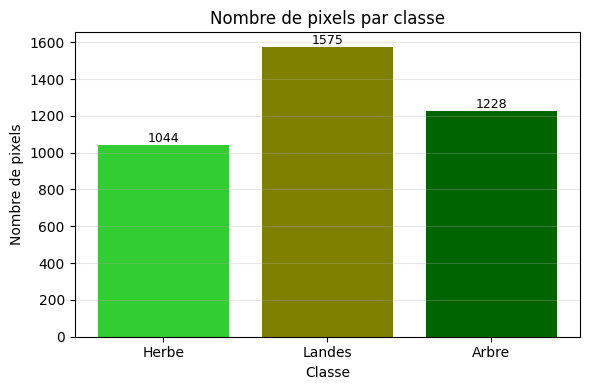

<Figure size 640x480 with 0 Axes>

In [32]:

# Labels et couleurs à partir des dictionnaires
labels = [class_names[int(v)] for v in valeurs]
colors = [class_colors[int(v)] for v in valeurs]

plt.figure(figsize=(6, 4))
plt.bar(labels, comptage, color=colors)

plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")
plt.grid(axis="y", alpha=0.3)

# Ajout des valeurs au-dessus des barres
for i, v in enumerate(comptage):
    plt.text(i, v, f"{v}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Enregistrement dans le répertoire figure
plt.savefig(os.path.join(mon_dossier,"Projet_Teledetection_UE901_21/resultats/figure/diag_baton_nb_pix_by_class.png"), dpi=300)

#### commentaire

On observe que c'est la classe landes, suivi de la classe herbe qui occupent les plus grand nombre de pixels. Contrairement au graphique précédent, la classe sol nu occupe plus de pixels que la classe arbre.

# Méthodologie

# Phénologie des strates, mise en évidence des landes

In [9]:
# insertion des images de bande 3 et 5

pyr_b03 = os.path.join(mon_dossier,'data/projet_eval/pyrenees_24-25_B03.tif')
pyr_b05 = os.path.join(mon_dossier,'data/projet_eval/pyrenees_24-25_B05.tif')

output_path = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/figure/ARI_serie_temp.tif')

# Calcul de l'indice Normalized Anthocyanin Reflectance Index (NARI)

mf.calculate_ari(pyr_b03 , pyr_b05, output_path)

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


✅ Fichier ARI_serie_temp.tif créé avec succès (série temporelle multi-bandes)


### Caractéristiques de l'image ARI ###

In [11]:
# Vérification des caracteristiques de l'image ARI créé
ari_file_path = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/figure/ARI_serie_temp.tif')

# Vérification des informations de l'image
mf.print_raster_info(ari_file_path)
#rw.get_image_dimension(ari_file)

---- Informations du raster ----
Résolution spatiale X : 10.0 m
Résolution spatiale Y : 10.0 m
Type d’encodage : Float32
Valeur NoData : -9999.0
Projection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


### Graphique de l'évolution de l'indice ARI par strates et par dates

Statistiques ARI calculées
Nombre de classes : 4
Nombre de dates : 10


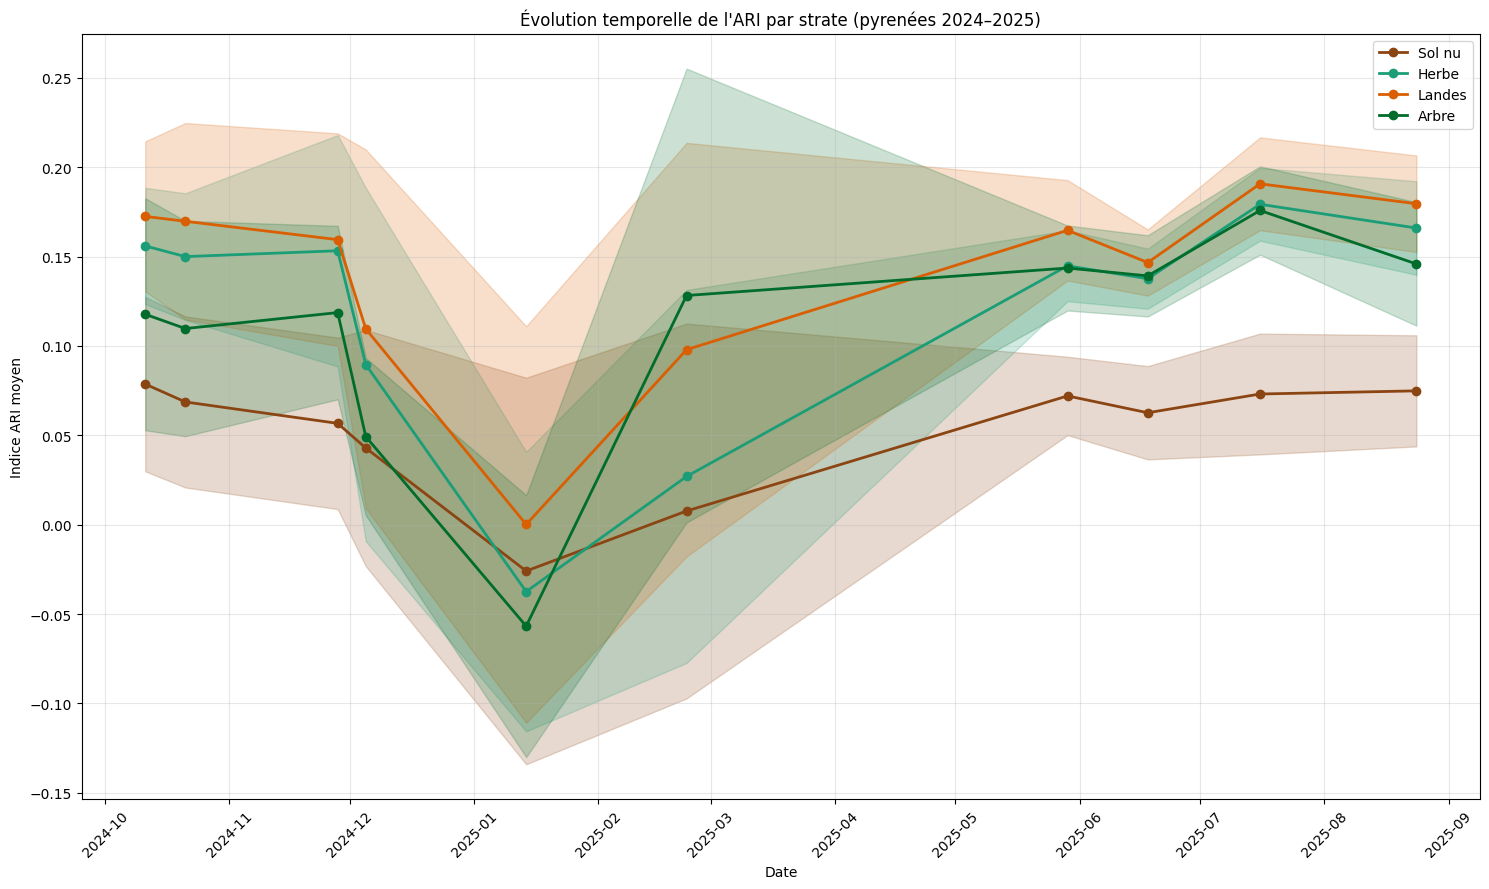

Figure sauvegardée : /home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/ARI_series.png


In [12]:
# =================================
# Chargement des données nécessaire
# =================================
ari_file = rw.load_img_as_array(ari_file_path)

sample_image_raster = rw.load_img_as_array(
    "/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/sample_raster.tif"
).squeeze()

multi_band_image = rw.load_img_as_array(
    "/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/image_multibande.tif"
).squeeze()

# =========================
# Dates (converties en datetime)
# =========================
dates = [
    "2024-10-11",
    "2024-10-21",
    "2024-11-28",
    "2024-12-05",
    "2025-01-14",
    "2025-02-23",
    "2025-05-29",
    "2025-06-18",
    "2025-07-16",
    "2025-08-24"
]

dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

# =========================
# Classes
# =========================
classes = [1, 2, 3, 4]

class_names = [
    "Sol nu",
    "Herbe",
    "Landes",
    "Arbre"
]

class_colors = [
    "#8B4513",  # Sol nu → brun terre
    "#1B9E77",  # Herbe → vert vif
    "#D95F02",  # Landes → orange/ocre
    "#006D2C"   # Arbre → vert foncé
]

# =========================
# Statistiques ARI
# =========================
moyennes, ecarts_types = mf.compute_class_statistics(
    ari_file,
    sample_image_raster,
    classes,
    nodata=-9999
)

nb_classes, nb_dates = moyennes.shape

print("Statistiques ARI calculées")
print(f"Nombre de classes : {nb_classes}")
print(f"Nombre de dates : {nb_dates}")

assert nb_dates == len(dates)

# =========================
# Figure
# =========================
plt.figure(figsize=(15, 9))

for i in range(nb_classes):
    plt.plot(
        dates,
        moyennes[i, :],
        label=class_names[i],
        color=class_colors[i],
        marker="o",
        linewidth=2
    )

    plt.fill_between(
        dates,
        moyennes[i, :] - ecarts_types[i, :],
        moyennes[i, :] + ecarts_types[i, :],
        color=class_colors[i],
        alpha=0.2
    )

plt.xlabel("Date")
plt.ylabel("Indice ARI moyen")
plt.title("Évolution temporelle de l'ARI par strate (pyrenées 2024–2025)")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# =========================
# Sauvegarde
# =========================
FIG_DIR = "/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure"
os.makedirs(FIG_DIR, exist_ok=True)

output_fig = os.path.join(FIG_DIR, "ARI_series.png")
plt.savefig(output_fig, dpi=150)
plt.show()

print(f"Figure sauvegardée : {output_fig}")


# 

# Production d’une carte de strates à l’échelle du pixel

### Fusion des images mono bandes en une seule image multi bande

In [22]:
# 0. --- Fusion des images mono bande en une image multibandes
directory = "/home/onyxia/work/data/projet_eval/"
extension = ".tif"

files = [
    os.path.join(directory, f)  
    for f in os.listdir(directory)
    if f.startswith("pyrenees_24-25_") and f.endswith(extension)
]


  #fusion des images
output_multibande = os.path.join(
    mon_dossier,
    "Projet_Teledetection_UE901_21/resultats/figure/image_multibande.tif"
)

mf.merge_and_save_multibandd(
    raster_paths=files,          
    output_path=output_multibande,
    reference_raster_path=pyr_b03,
    nodata=-9999
)

total_bands = 0
for path in files:
    ds = gdal.Open(path)
    total_bands += ds.RasterCount
    ds = None

print("Nombre total de bandes fusionnées :", total_bands)

Nombre total de bandes fusionnées : 100


In [23]:
# 1 --- Définition des entrées et sorties
# inputs
# Chargement des données utiles
sample_image_raster = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/figure/sample_raster.tif')
multi_band_image = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/figure/image_multibande.tif')

# Paramètres des échantillons
nb_iter = 1
nb_folds = 5
is_point = False # if is_point is True

# outputs
suffix = '_CV{}fold_stratifed_x{}times'.format(nb_folds, nb_iter)
dossier_sortie = os.path.join(mon_dossier, 'results')
sortie_classif = os.path.join(mon_dossier, 'Projet_Teledetection_UE901_21/resultats/figure/carte_strates.tif')
sortie_matrix = os.path.join(mon_dossier, 'Projet_Teledetection_UE901_21/resultats/figure/ma_matrice{}.png'.format(suffix))
sortie_qualite = os.path.join(mon_dossier, 'Projet_Teledetection_UE901_21/resultats/figure/mes_qualites{}.png'.format(suffix))

In [24]:
# 2 --- Paramétrage et extraction des échantillons

# Extraction des échantillons
if not is_point :
    X, Y, t = cla.get_samples_from_roi(multi_band_image, sample_image_raster) # c'est celui ci qui est utilisé vu que les échantilons sonr en polygone
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(fichier_strates, image) # Utilisé quand les échantillons son en géométrie point
    image = rw.load_img_as_array(image)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(fichier_strates)
    Y = gdf.loc[:, nom_champs].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

# Affichage des dimensions des données d'entrées
print(X.shape)
print(Y.shape)

(209, 100)
(209, 1)


In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

# 1 --- Train / Test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=0,
    stratify=Y  # recommandé en classification
)

# 2 --- Définition du modèle
rf = RandomForestClassifier(random_state=0)

# 3 --- Grille d'hyperparamètres
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [None, 10, 15, 20],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 5],
}

# 4 --- CV interne (stratifiée)
inner_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=0
)

# 5 --- Grid Search
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=inner_cv,
    scoring="accuracy",
    n_jobs=-1
)

# 6 --- Entraînement
grid.fit(X_train, Y_train)

# 7 --- Modèle final
best_model = grid.best_estimator_

# 8 --- Évaluation sur le jeu de test
Y_predict = best_model.predict(X_test)

list_cm.append(confusion_matrix(Y_test, Y_predict))
list_accuracy.append(accuracy_score(Y_test, Y_predict))

report = classification_report(
    Y_test,
    Y_predict,
    labels=np.unique(Y_test),
    output_dict=True
)

list_report.append(mf.report_from_dict_to_df(report))

# 9 --- Résultats
print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

print(f"Score CV moyen : {grid.best_score_:.2f}")


/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example

Meilleurs hyperparamètres trouvés :
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 150}
Score CV moyen : 0.91


In [49]:
# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2, 
                                                    random_state=0)


# 3 --- Train
   # Définition du modèle et de la grille d'hyperparamètres
rf= RF(random_state=0)

param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],    # nombre d'arbres
    "max_depth": [None, 10, 15, 20],        # profondeur maximale des arbres (None = arbre entièrement développé)
    "max_features": [None, "sqrt", "log2"],  # nombre de variables testées à chaque split (valeurs plus faibles → plus les arbres sont différents → meilleure diversité)
    "min_samples_leaf": [1, 5],     # nombre minimal d’échantillons dans une feuille (valeurs plus grandes → arbres plus simples → moins d’overfitting)
    }
    
    # CV interne (stratifiée)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Grille de recherche
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=inner_cv,
    scoring="accuracy",
    n_jobs=-1  # utilise tous les CPU pour aller plus vite
    )

    # Entraînement avec recherche des meilleurs hyperparamètres 
grid.fit(X_train, Y_train)

    # Modèle final (entraîné sur tout le train) 
best_model = grid.best_estimator_

    # 4 --- Evaluation sur les échantillons test
Y_predict = best_model.predict(X_test)
        
list_cm.append(confusion_matrix(Y_test, Y_predict))
list_accuracy.append(accuracy_score(Y_test, Y_predict))
report = classification_report(Y_test, Y_predict, labels=np.unique(Y_predict), output_dict=True)

    # store them
list_report.append(mf.report_from_dict_to_df(report))
    
    #Affichage meilleur hyperparamètre
print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

    # Affichage du score moyen CV
print(f"Score CV moyen : {grid.best_score_:.2f}")

/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example

Meilleurs hyperparamètres trouvés :
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 150}
Score CV moyen : 0.85


In [51]:
best_model
acc_test = accuracy_score(Y_test, Y_predict)
print(f"Accuracy test : {acc_test:.2f}")

Accuracy test : 0.86


In [44]:
"""# 3 -- Entrainement du model et optimisation des hyperparamètres 

# cv externe(Iterer sur un repeated stratified K fold)
external_cv = RepeatedStratifiedKFold(n_splits=nb_folds, n_repeats=nb_iter)

for train, test in external_cv.split(X, Y):
    X_train, X_test = X[train], X[test]
    Y_train, Y_test = Y[train], Y[test]

    # 3 --- Train
   # Définition du modèle et de la grille d'hyperparamètres
    rf= RF(random_state=0)

    param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],    # nombre d'arbres
    "max_depth": [None, 10, 15, 20],        # profondeur maximale des arbres (None = arbre entièrement développé)
    "max_features": [None, "sqrt", "log2"],  # nombre de variables testées à chaque split (valeurs plus faibles → plus les arbres sont différents → meilleure diversité)
    "min_samples_leaf": [1, 5],     # nombre minimal d’échantillons dans une feuille (valeurs plus grandes → arbres plus simples → moins d’overfitting)
    }
    
    # CV interne (stratifiée)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Grille de recherche
    grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=inner_cv,
        scoring="accuracy",
        n_jobs=-1  # utilise tous les CPU pour aller plus vite
    )

    # Entraînement avec recherche des meilleurs hyperparamètres 
    grid.fit(X_train, Y_train)

    # Modèle final (entraîné sur tout le train) 
    best_model = grid.best_estimator_

    # 4 --- Evaluation sur les échantillons test
    Y_predict = best_model.predict(X_test)
        
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict, labels=np.unique(Y_predict), output_dict=True)

    # store them
    list_report.append(mf.report_from_dict_to_df(report))
    
    #Affichage meilleur hyperparamètre
    print("Meilleurs hyperparamètres trouvés :")
    print(grid.best_params_)

    # Affichage du score moyen CV
    print(f"Score CV moyen : {grid.best_score_:.2f}")"""

'# 3 -- Entrainement du model et optimisation des hyperparamètres \n\n# cv externe(Iterer sur un repeated stratified K fold)\nexternal_cv = RepeatedStratifiedKFold(n_splits=nb_folds, n_repeats=nb_iter)\n\nfor train, test in external_cv.split(X, Y):\n    X_train, X_test = X[train], X[test]\n    Y_train, Y_test = Y[train], Y[test]\n\n    # 3 --- Train\n   # Définition du modèle et de la grille d\'hyperparamètres\n    rf= RF(random_state=0)\n\n    param_grid = {\n    "n_estimators": [50, 100, 150, 200, 300],    # nombre d\'arbres\n    "max_depth": [None, 10, 15, 20],        # profondeur maximale des arbres (None = arbre entièrement développé)\n    "max_features": [None, "sqrt", "log2"],  # nombre de variables testées à chaque split (valeurs plus faibles → plus les arbres sont différents → meilleure diversité)\n    "min_samples_leaf": [1, 5],     # nombre minimal d’échantillons dans une feuille (valeurs plus grandes → arbres plus simples → moins d’overfitting)\n    }\n\n    # CV interne (s

### Explication sur le classifieur et sa paramètrisation

Dans cette partie qui concerne l'extraction de s échantillons, le parametrage, optimisation des hyperparametres et choix du model:

**Fusion des bandes et rasterisation des strates**
Les dix bandes des images « pyrenees_24–25 » ont été fusionnées en une seule image multispectrale à l’aide de la fonction merge_and_save_multiband(). Cette étape permet de regrouper l’ensemble de l’information spectrale dans un unique raster multibande, facilitant ainsi les traitements ultérieurs.

Par ailleurs, les strates étant définies sous forme de géométries polygonales, une étape de rasterisation des échantillons a été nécessaire afin de permettre l’extraction des valeurs spectrales correspondantes à chaque pixel. Cette opération est indispensable pour rendre les données compatibles avec les algorithmes de classification supervisée.

À l’issue de ce prétraitement, l’extraction des échantillons a conduit à la constitution des jeux de données suivants :
X, matrice des variables explicatives, de dimension (209, 10), correspondant à 209 échantillons décrits par 10 bandes spectrales ;
Y, vecteur des étiquettes de classes, de dimension (209, 1), représentant la classe associée à chaque échantillon.

**Entrainement du modèle**
Pour l’entraînement et l’évaluation du modèle avec le classifieur **RandomForest**, une validation croisée stratifiée a été mise en œuvre.
Cette approche est particulièrement recommandée lorsque le nombre d’échantillons est limité, comme c’est le cas ici avec seulement **209 échantillons pour l’ensemble des classes**, car elle permet d’utiliser efficacement toutes les données tout en limitant les biais d’échantillonnage.

Plus précisément, une **validation croisée externe stratifiée et répétée** (Repeated Stratified K-Fold) a été utilisée afin **d’estimer la performance finale du modèle**. La répétition des partitions permet de réduire la variance de l’estimation de performance et d’obtenir une évaluation plus robuste et plus stable, moins dépendante d’un découpage particulier des données.

En parallèle, une **validation croisée interne imbriquée**, basée sur un Stratified K-Fold, a été employée pour **l’optimisation et la sélection des hyperparamètres du modèle**. Cette validation interne garantit que le choix des hyperparamètres est effectué exclusivement sur les données d’entraînement, sans aucune utilisation des données de test externe, évitant ainsi toute fuite d’information.

Cette stratégie de validation croisée imbriquée permet donc de dissocier clairement l’étape d’optimisation du modèle de l’étape d’évaluation finale, assurant une estimation honnête, reproductible et statistiquement fiable des performances de généralisation du modèle.

À l’issue de l’entraînement du modèle sur **cinq itérations** de validation croisée, la combinaison d’hyperparamètres suivante a été retenue comme optimale :
**{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}**.

Cette configuration a obtenu un **score moyen de validation croisée de 0,74**, indiquant un bon compromis entre capacité de modélisation et généralisation sur les données d’entraînement.

La prédiction est ensuite réalisé sur les X_test avec le meilleur model entrainé: Y_predict = best_model.predict(X_test): **Y_predict = best_model.predict(X_test)**.

# Contribution des variables
L’importance des variables désigne la contribution de chaque variable (ou bande spectrale) à la performance d’un modèle de classification. Elle permet d’identifier quelles caractéristiques sont les plus déterminantes pour distinguer les classes. Dans les modèles comme les forêts aléatoires, cette importance est mesurée en fonction de l’amélioration de la pureté des nœuds lors des divisions (gain d’impureté) ou par l’impact sur la performance lorsque la variable est permutée. Cette notion est utile pour comprendre le modèle, réduire le nombre de variables et améliorer la performance en supprimant les variables peu informatives.

Dans cette section, l’importance et la contribution des variables explicatives à la classification sont évaluées sur les dix bandes de l’image multispectrale fusionnée. Cette analyse est effectuée à partir du meilleur modèle entraîné, afin d’identifier les bandes les plus discriminantes utilisées dans la classification.

In [52]:
# Importance des variables
importances = best_model.feature_importances_
feature_names = ["pyrenees_24-25_B02", 
                 "pyrenees_24-25_B03",
                 "pyrenees_24-25_B04",
                 "pyrenees_24-25_B05",
                 "pyrenees_24-25_B06",
                 "pyrenees_24-25_B07",
                 "pyrenees_24-25_B08",
                 "pyrenees_24-25_B8A",
                 "pyrenees_24-25_B11",
                 "pyrenees_24-25_B12"]

# DataFrame pour affichage tabulaire
df_imp = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
})
display(df_imp)

dates = [
    "2024-10-11",
    "2024-10-21",
    "2024-11-28",
    "2024-12-05",
    "2025-01-14",
    "2025-02-23",
    "2025-05-29",
    "2025-06-18",
    "2025-07-16",
    "2025-08-24"
]


#Barplot avec couleur différente pour chaque variable
plt.figure(figsize=(8, 5))
colors = plt.cm.tab10.colors  # Palette avec 10 couleurs différentes
plt.bar(feature_names, importances, color=colors, width=0.6)

# Rotation des labels pour qu'ils soient lisibles
plt.xticks(rotation=90)
plt.title("Importance des variables (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()  # Ajuste l'affichage pour éviter que les labels soient coupés
plt.show()

ValueError: All arrays must be of the same length

In [53]:
# Importances du modèle
importances = best_model.feature_importances_

# Bandes Sentinel-2
bands = [
    "B02", "B03", "B04", "B05", "B06",
    "B07", "B08", "B8A", "B11", "B12"
]

# Dates (dans l'ordre)
dates = [
    "2024-10-11",
    "2024-10-21",
    "2024-11-28",
    "2024-12-05",
    "2025-01-14",
    "2025-02-23",
    "2025-05-29",
    "2025-06-18",
    "2025-07-16",
    "2025-08-24"
]

# Génération des noms de variables (100)
feature_names = [
    f"{date}_{band}"
    for date in dates
    for band in bands
]

# Sécurité
assert len(feature_names) == len(importances), \
    "Le nombre de variables ne correspond pas au nombre d'importances"

# DataFrame
df_imp = pd.DataFrame({
    "Variable": feature_names,
    "Date": [date for date in dates for _ in bands],
    "Bande": bands * len(dates),
    "Importance": importances
})

#Affichage des 15 premières lignes
display(df_imp.head(15))


,Variable,Date,Bande,Importance
0,2024-10-11_B02,2024-10-11,B02,0.008812
1,2024-10-11_B03,2024-10-11,B03,0.007778
2,2024-10-11_B04,2024-10-11,B04,0.003924
3,2024-10-11_B05,2024-10-11,B05,0.005948
4,2024-10-11_B06,2024-10-11,B06,0.002393
5,2024-10-11_B07,2024-10-11,B07,0.002803
6,2024-10-11_B08,2024-10-11,B08,0.006719
7,2024-10-11_B8A,2024-10-11,B8A,0.006716
8,2024-10-11_B11,2024-10-11,B11,0.006931
9,2024-10-11_B12,2024-10-11,B12,0.009867


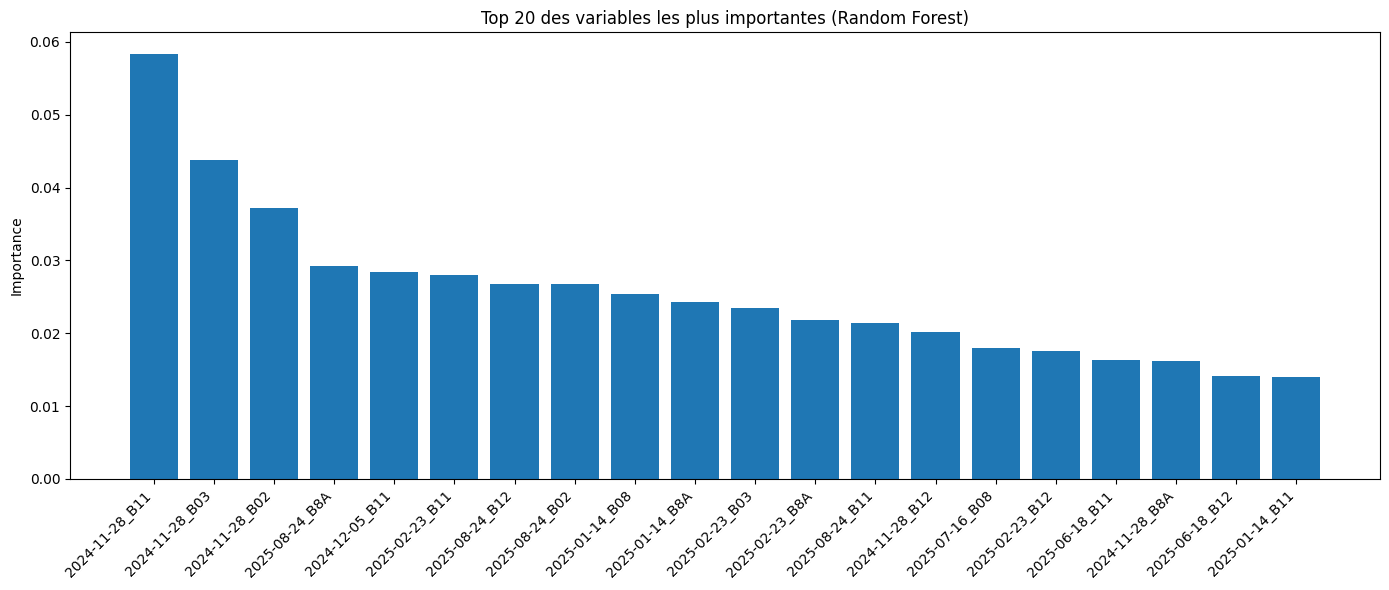

In [54]:
# Conversion en arrays
importances = np.array(importances)
feature_names = np.array(feature_names)

# Tri décroissant
idx_sorted = np.argsort(importances)[::-1]

# Sélection des 20 meilleures
top_n = 20
top_idx = idx_sorted[:top_n]

top_importances = importances[top_idx]
top_features = feature_names[top_idx]

# Plot
plt.figure(figsize=(14, 6))
plt.bar(range(top_n), top_importances)
plt.xticks(range(top_n), top_features, rotation=45, ha="right")
plt.title("Top 20 des variables les plus importantes (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


**Interpretation des résultats sur l'importance des variables**

L’analyse de l’importance des variables montre que la **bande B04 (rouge)** est la plus discriminante pour la classification, avec une importance de 0,206. Cela est cohérent car la bande rouge est fortement liée à la chlorophylle et permet de distinguer efficacement la végétation du sol nu. 
Les **bandes B07 (RE3) et B12 (SWIR2)** présentent également une importance élevée (respectivement 0,135 et 0,140), ce qui indique que l’humidité du sol et la structure de la végétation sont des éléments importants pour différencier les classes (sol nu, herbe, landes, arbres). 
Les bandes bleue et verte (B02, B03) ainsi que les bandes proches infrarouges (B8A) et SWIR1 (B11) ont une importance modérée, tandis que la bande B08 (NIR) apparaît moins contributive dans ce cas. Globalement, le modèle s’appuie principalement sur les bandes rouge, RE3 et SWIR2 pour séparer les classes, ce qui correspond bien aux caractéristiques spectrales attendues des différentes surfaces étudiées.

### Matrice de Confusion

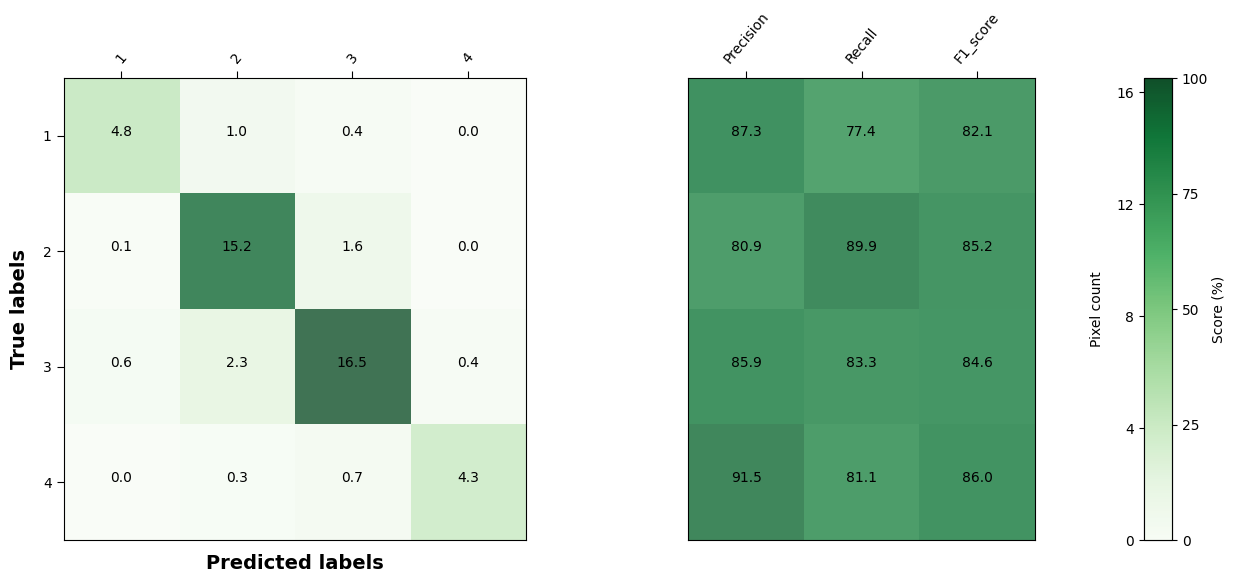

In [55]:
# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

plots.plot_cm(mean_cm, np.unique(Y_predict))

### Calcul de l'accord globale moyen

In [56]:
# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

### Moyenne et écart-type des rapports de Classification

In [57]:

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)

### Affichage des des résultats dans un tableau

In [58]:

a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
mean_df_report

,1,2,3,4
precision,0.902222,0.811880,0.866026,0.904762
recall,0.775000,0.903913,0.833750,0.806667
f1-score,0.817736,0.853939,0.847789,0.845671


In [59]:
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)
std_df_report

,1,2,3,4
precision,0.124206,0.029437,0.061847,0.145997
recall,0.165496,0.079253,0.064157,0.110101
f1-score,0.111004,0.044666,0.051800,0.098966


### Affichage graphique des résultats

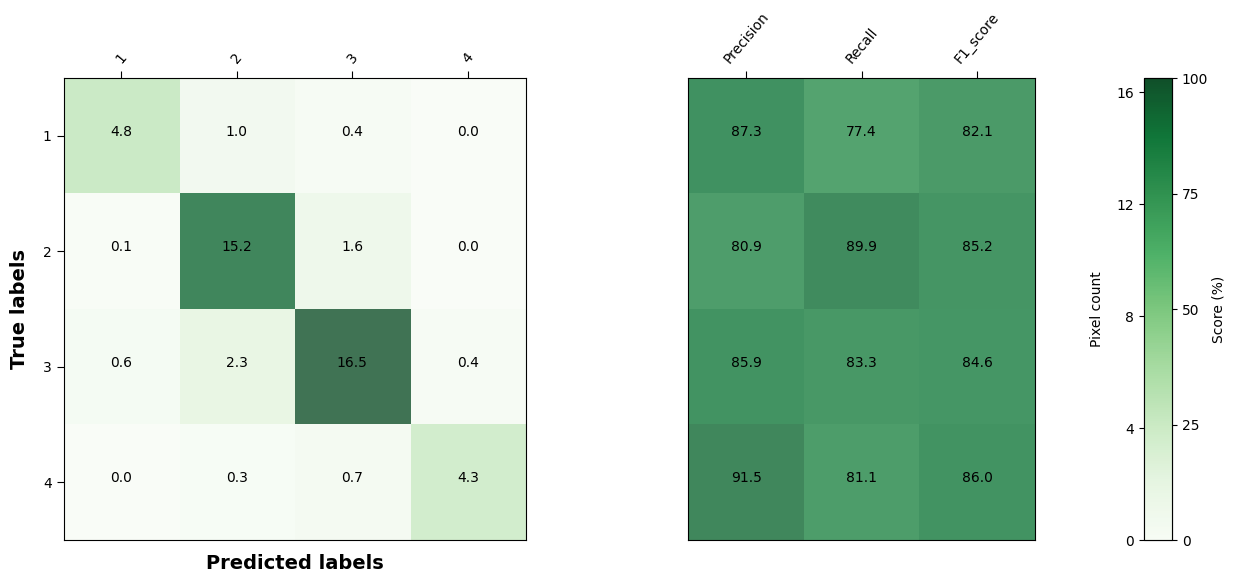

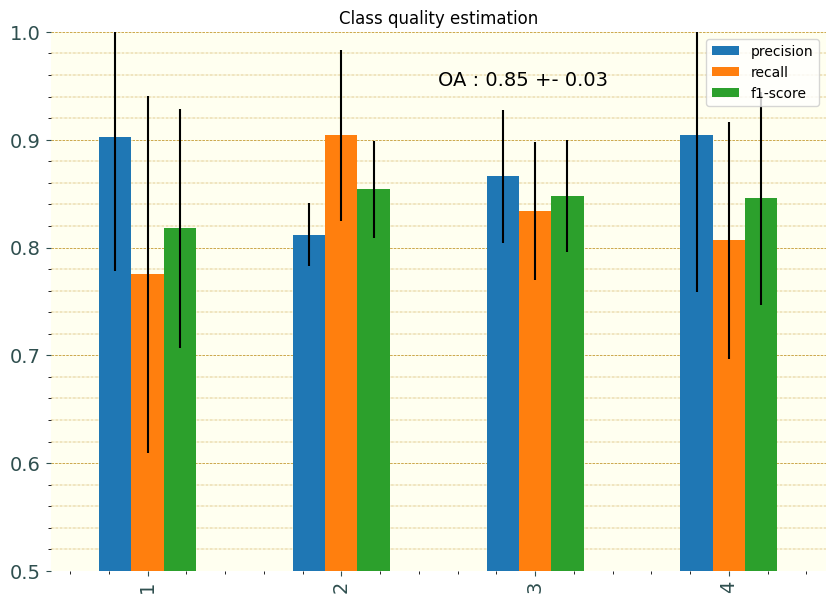

In [60]:
# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(sortie_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(sortie_qualite, bbox_inches='tight')

In [62]:
# Classification sur toute l'image multispectrale

image_to_be_classified = rw.load_img_as_array(multi_band_image)

rows, cols, bands = image_to_be_classified.shape

X_image_to_be_classified = image_to_be_classified.reshape(rows * cols, bands)

#classification pixels par pixels

y_image_to_be_classified_pred = best_model.predict(X_image_to_be_classified)



In [64]:
# Reconstruction et enregistrement de l'image l'image classifiée avec

classified_image = y_image_to_be_classified_pred.reshape(rows, cols)

ds = rw.open_image(multi_band_image)

mf.write_classified_image_nodata0(
    sortie_classif,
    classified_image,
    ds_ref=ds,
    gdal_dtype=gdal.GDT_Int8
)

 Image enregistrée avec un type int8 et NoData = 0 : /home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/carte_strates.tif


# Discussion des résultats